In [79]:
import os
import sys
### Append the project root directory to sys.path
sys.path.append(os.path.abspath("/Users/prashal/dev/Face-Detector"))

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from math import ceil
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.object_detection_2d_geometric_ops import Resize

from misc_utils.utils import create_virtual_folder, format_labels

##### Define model configuration parameters

In [50]:
img_height = 300
img_width = 480
img_channels = 3
intensity_mean = 127.5  
intensity_range = 127.5 
n_classes = 1
min_scale = 0.07
max_scale = 0.9
aspect_ratios = [0.5, 1.0, 2.0]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [1.0, 1.0, 1.0, 1.0]
normalize_coords = True

##### Build the keras model

In [51]:
ssd = build_model(
    image_size=(img_height, img_width, img_channels),
    n_classes=n_classes,
    mode="training",
    l2_regularization=0.0005,
    min_scale=min_scale,
    max_scale=max_scale,
    aspect_ratios_global=aspect_ratios,
    aspect_ratios_per_layer=None,
    two_boxes_for_ar1=two_boxes_for_ar1,
    steps=steps,
    offsets=offsets,
    clip_boxes=clip_boxes,
    variances=variances,
    normalize_coords=normalize_coords,
    subtract_mean=intensity_mean,
    divide_by_stddev=intensity_range,
)

adam = Adam(learning_rate=0.001)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
ssd.compile(optimizer=adam, loss=ssd_loss.compute_loss)

##### Set up the data generators

In [52]:
### Create symlinks to train-set
src_folder_train = os.path.abspath("../wider_face/data/WIDER_train/images")
virtual_folder_train = os.path.abspath("../dataset/train/images")
create_virtual_folder(src_folder_train, virtual_folder_train)
### Format training set ground truth labels
train_labels_file = os.path.abspath("../wider_face/data/wider_face_split/wider_face_train_bbx_gt.txt")
formatted_train_labels_file = os.path.abspath("../dataset/train/train_bbox.csv")
format_labels(train_labels_file, formatted_train_labels_file)

'Formatted file succesfully saved to /Users/prashal/dev/Face-Detector/dataset/train/train_bbox.csv'

In [53]:
### Create symlinks to validation-set
src_folder_val = os.path.abspath("../wider_face/data/WIDER_val/images")
virtual_folder_val = os.path.abspath("../dataset/val/images")
create_virtual_folder(src_folder_val, virtual_folder_val)
### Format validation set ground truth labels
val_labels_file = os.path.abspath("../wider_face/data/wider_face_split/wider_face_val_bbx_gt.txt")
formatted_val_labels_file = os.path.abspath("../dataset/val/val_bbox.csv")
format_labels(val_labels_file, formatted_val_labels_file)

'Formatted file succesfully saved to /Users/prashal/dev/Face-Detector/dataset/val/val_bbox.csv'

In [54]:
### Instantiate data generators
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

### Images
images_train = virtual_folder_train
images_val = virtual_folder_val

### Ground truth
labels_train = formatted_train_labels_file
labels_val = formatted_val_labels_file

train_dataset.parse_csv(
    images_dir=images_train,
    labels_filename=labels_train,
    input_format=["image_name", "xmin", "xmax", "ymin", "ymax", "class_id"],
    ### There are 4 images with only background in the train set. Their class id is set to 0. Therefore only include class id 1 (face).
    include_classes=[1],
)

val_dataset.parse_csv(
    images_dir=images_val,
    labels_filename=labels_val,
    input_format=["image_name", "xmin", "xmax", "ymin", "ymax", "class_id"],
    include_classes=[1],
)

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size = val_dataset.get_dataset_size()

print(f"Number of images in the training dataset: {train_dataset_size}")
print(f"Number of images in the validation dataset: {val_dataset_size}")

Number of images in the training dataset: 12876
Number of images in the validation dataset: 3226


In [55]:
batch_size = 16

# data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
#                                                             random_contrast=(0.5, 1.8, 0.5),
#                                                             random_saturation=(0.5, 1.8, 0.5),
#                                                             random_hue=(18, 0.5),
#                                                             random_flip=0.5,
#                                                             random_translate=((0.03,0.5), (0.03,0.5), 0.5),
#                                                             random_scale=(0.5, 2.0, 0.5),
#                                                             n_trials_max=3,
#                                                             clip_boxes=True,
#                                                             overlap_criterion='area',
#                                                             bounds_box_filter=(0.3, 1.0),
#                                                             bounds_validator=(0.5, 1.0),
#                                                             n_boxes_min=1,
#                                                             background=(0,0,0))

resize = Resize(height=img_height, width=img_width)

predictor_sizes = [ssd.get_layer('classes4').output.shape[1:3],
                   ssd.get_layer('classes5').output.shape[1:3],
                   ssd.get_layer('classes6').output.shape[1:3],
                   ssd.get_layer('classes7').output.shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    min_scale=min_scale,
                                    max_scale=max_scale,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[resize],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images', 'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images', 'encoded_labels'},
                                     keep_images_without_gt=False)

##### Train the model

In [56]:
### Create directories to save model checkpoints and csv loggers
os.makedirs(name='../tmp/checkpoints', exist_ok=True)
os.makedirs(name='../tmp/runs', exist_ok=True)

In [57]:
### Define model callbacks
model_checkpoint = ModelCheckpoint(filepath='../tmp/checkpoints/ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.keras',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   save_freq='epoch')

csv_logger = CSVLogger(filename='../tmp/runs/ssd_7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         min_delta=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint, 
             csv_logger, 
             early_stopping, 
             reduce_learning_rate]

##### Make predictions

In [231]:
### Load trained model weights

ssd.load_weights('../tmp/checkpoints/ssd7_epoch-13_loss-1.9770_val_loss-1.9923.keras')

In [232]:
### Set the generator for the predictions

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[resize],
                                         label_encoder=None,
                                         returns={'processed_images','processed_labels','filenames'},
                                         keep_images_without_gt=False)

In [261]:
### Generate samples

batch_images, batch_labels, batch_filenames = next(predict_generator)
i = 0
print("Image: {}\n".format(batch_filenames[i]))
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: /Users/prashal/dev/Face-Detector/dataset/val/images/2_Demonstration_Political_Rally_2_224.jpg

Ground truth boxes:

[[  1  47  76  84 122]
 [  1 157  37 194  88]
 [  1 284  47 324  98]
 [  1 366 106 395 152]
 [  1 422 114 455 155]]


In [262]:
### Make a prediction

y_pred = ssd.predict(batch_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [263]:
### Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.   281.86  47.09 317.11  98.34]
 [  1.     1.   364.47 108.4  394.72 152.19]
 [  1.     0.99  46.25  73.87  82.79 122.59]
 [  1.     0.93 162.42  45.21 196.53  87.72]
 [  1.     0.76 421.58 114.9  450.33 156.5 ]
 [  1.     0.73  57.79 113.86  75.07 136.48]]


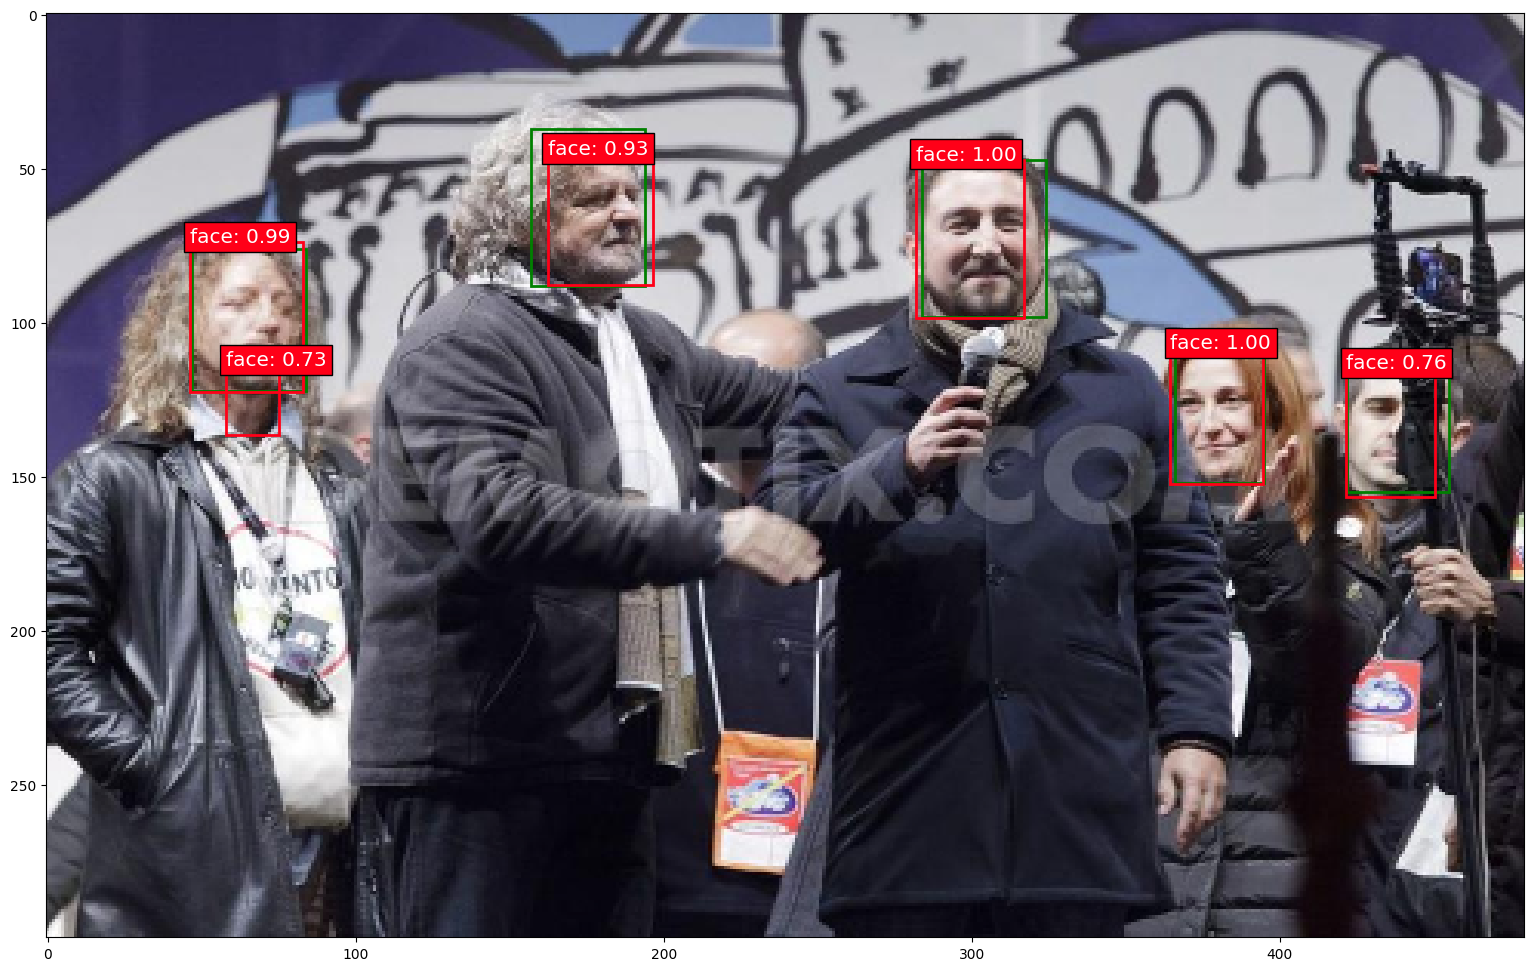

In [264]:
### Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'face'] # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in red
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})